The basic expiremental setup here is we have a stock dataset for the price of GOOG for 50 different samples. Each sample represents a sequence of 10 prices of GOOG in the stock market that are ordered timewise.
The columns in the dataset are [seq_id,	seq_time_id, seq_temporal_Close, seq_temporal_High,	seq_temporal_Low, seq_temporal_Open, seq_temporal_Volume, seq_out_Open_next]. All the columns represent temporal data except seq_id which is the id of the current sample and seq_out_Open_next which represents the open of the next day. I'm using all the columns to predict the close of the stock price in the 10th sample given. I'm using an LSTM layer with a dropout and then a linear layer to produce the close since this data isn't too complex. I trained the model with Adam and MSE loss.

In [54]:
import matplotlib.pyplot as plt

In [55]:
import sys
from os.path import dirname
sys.path.append(dirname('./synthcity/src/'))

In [56]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [59]:
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks

In [60]:
from synthcity.utils.datasets.time_series.pbc import PBCDataloader
from synthcity.utils.datasets.time_series.google_stocks import GoogleStocksDataloader
from synthcity.plugins.core.dataloader import TimeSeriesDataLoader

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig

In [63]:
from gretel_synthetics.timeseries_dgan.config import DfStyle

In [64]:
(static_data, temporal_data,observation_times, outcome) = GoogleStocksDataloader().load()

In [65]:
data = pd.read_csv("data/StockPrices.csv")

In [66]:
data.drop("Unnamed: 0", axis = 1, inplace=True)

In [67]:
seq_len = 10

In [68]:
data

,Date,Open,High,Low,Close,Volume
0,09/26/2005,7.995495,8.031782,7.821822,7.864865,395380224
1,09/27/2005,7.881632,7.968218,7.842342,7.856356,274649076
2,09/28/2005,7.863363,7.885385,7.647648,7.657658,319576104
3,09/29/2005,7.674675,7.775776,7.659660,7.748248,224327448
4,09/30/2005,7.863363,7.945445,7.815065,7.919419,365685948
...,...,...,...,...,...,...
4525,09/19/2023,137.419998,138.410004,136.619995,138.039993,20353700
4526,09/20/2023,138.080002,138.080002,133.619995,133.740005,29927500
4527,09/21/2023,131.440002,132.229996,130.070007,130.440002,31488700
4528,09/22/2023,130.759995,132.029999,129.600006,130.250000,26385200


In [69]:
data['Open'] = data['Open']/data['Open'].abs().max()
data['Volume'] = data['Volume']/data['Volume'].abs().max()
data['Close'] = data['Close']/data['Close'].abs().max()
data['High'] = data['High']/data['High'].abs().max()
data['Low'] = data['Low']/data['Low'].abs().max()

In [70]:
data

,Date,Open,High,Low,Close,Volume
0,09/26/2005,0.052863,0.052999,0.052531,0.052489,0.240642
1,09/27/2005,0.052110,0.052579,0.052669,0.052432,0.167161
2,09/28/2005,0.051989,0.052033,0.051361,0.051106,0.194505
3,09/29/2005,0.050742,0.051310,0.051442,0.051711,0.136533
4,09/30/2005,0.051989,0.052429,0.052486,0.052853,0.222569
...,...,...,...,...,...,...
4525,09/19/2023,0.908562,0.913317,0.917535,0.921259,0.012388
4526,09/20/2023,0.912926,0.911140,0.897387,0.892561,0.018215
4527,09/21/2023,0.869025,0.872537,0.873545,0.870537,0.019165
4528,09/22/2023,0.864529,0.871218,0.870389,0.869269,0.016059


In [71]:
horizons = []
for i in range(0, len(data), seq_len):
    x = data.loc[i:i + seq_len-1]
    T = (pd.to_datetime(x["Date"], infer_datetime_format=True).astype(np.int64).astype(np.float64)/10**9
    )
    T = pd.Series(MinMaxScaler().fit_transform(T.values.reshape(-1, 1)).squeeze())
    horizons += T.values.tolist()

In [72]:
data["Horizons"] = horizons

In [73]:
data["Open_next"] = 0

In [74]:
open_next = []
i = 0
for i in range(0, len(data), seq_len):
    if i + seq_len >= len(data):
        continue
    open_next += [data.iloc[i + seq_len]["Open"]]*seq_len

In [75]:
data = data.iloc[:len(data)-seq_len].copy(deep=True)

In [76]:
len(data)

4520

In [77]:
data["Open_next"] = open_next

In [78]:
data.drop("Date", axis = 1, inplace = True)

In [79]:
user_data = []
for i in range(0, len(data), seq_len):
    if i >= len(data):
        continue
    x = data.loc[i:i + seq_len-1]
    user_data.append(x)

In [80]:
len(user_data)

452

In [81]:
train_data, test_data = train_test_split(user_data, test_size=0.2)

In [82]:
temporal_cols = ["Open", "High", "Low",
                      "Close", "Volume"]
horizon_cols = ["Horizons"]
outcome_cols = ["Open_next"]

In [83]:
train_data[0]

,Open,High,Low,Close,Volume,Horizons,Open_next
2390,0.186661,0.187134,0.187479,0.188082,0.030336,0.000000,0.181676
2391,0.185729,0.186105,0.187016,0.186050,0.021030,0.071429,0.181676
2392,0.185207,0.185474,0.186969,0.187248,0.015087,0.285714,0.181676
2393,0.184443,0.185570,0.186257,0.185099,0.021261,0.357143,0.181676
2394,0.183415,0.184267,0.183356,0.183361,0.023677,0.428571,0.181676
2395,0.180962,0.180803,0.181479,0.180631,0.029068,0.500000,0.181676
2396,0.178129,0.179991,0.179887,0.181512,0.020522,0.785714,0.181676
2397,0.180162,0.181515,0.182536,0.181816,0.016627,0.857143,0.181676
2398,0.180496,0.181957,0.183346,0.183144,0.017277,0.928571,0.181676
2399,0.181557,0.181255,0.181986,0.182870,0.019699,1.000000,0.181676


In [84]:
temporal_dataframes = []
outcomes = []
horizons = []
for sample in train_data:
    temporal_dataframes.append(sample[temporal_cols])
    outcomes.append(sample[outcome_cols].iloc[-1][0])
    x = sample[horizon_cols].values.tolist()
    lst = []
    for horizon in x:
        lst.append(horizon[0])
    horizons.append(lst)
outcomes = pd.DataFrame(outcomes, columns=["Open_next"])

In [85]:
train_data_loader = TimeSeriesDataLoader(
    temporal_data=temporal_dataframes,
    observation_times=horizons,
    static_data=pd.DataFrame(np.zeros((len(temporal_dataframes), 0))),
    outcome = outcomes,
)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


In [86]:
temporal_dataframes = []
outcomes = []
horizons = []
for sample in test_data:
    temporal_dataframes.append(sample[temporal_cols])
    outcomes.append(sample[outcome_cols].iloc[-1][0])
    x = sample[horizon_cols].values.tolist()
    lst = []
    for horizon in x:
        lst.append(horizon[0])
    horizons.append(lst)
outcomes = pd.DataFrame(outcomes, columns=["Open_next"])

In [87]:
test_data_loader = TimeSeriesDataLoader(
    temporal_data=temporal_dataframes,
    observation_times=horizons,
    static_data=pd.DataFrame(np.zeros((len(temporal_dataframes), 0))),
    outcome = outcomes,
)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


In [88]:
delta = 1/ (len(data/10) * np.log(len(data/10)))

In [33]:
syn_model_without_dp = Plugins().get("timegan", dp_enabled=False)

[2023-10-01T15:23:36.786260+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T15:23:36.793365+0000][2012][CRITICAL] load failed: 
GReaT is not installed. Please install it with pip install GReaT.
Please be aware that GReaT is only available for python >= 3.9.

[2023-10-01T15:23:36.794359+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:36.795345+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T15:23:36.804925+0000][2012][CRITICAL] load failed: No module named 'nflows'
[2023-10-01T15:23:36.805877+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:36.806780+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T15:23:36.936655+0000][2012][CRITICAL] load failed: No module named 'pytorch_lightning'
[2023-10-01T15:2

In [34]:
syn_model_with_dp_eps1 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=1., delta = delta)

[2023-10-01T15:23:37.418290+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T15:23:37.420627+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:37.421795+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:37.422907+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T15:23:37.424225+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:37.425294+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:37.426362+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T15:23:37.428003+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

In [35]:
syn_model_with_dp_eps5 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=5., delta = delta)

[2023-10-01T15:23:37.469371+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T15:23:37.471705+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:37.472874+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:37.473938+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T15:23:37.475397+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:37.477678+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:37.478788+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T15:23:37.480615+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

In [36]:
syn_model_with_dp_eps20 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=20., delta = delta)

[2023-10-01T15:23:37.518648+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T15:23:37.520902+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:37.522098+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T15:23:37.523320+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T15:23:37.525787+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:37.527030+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T15:23:37.528171+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T15:23:37.529814+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

In [37]:
syn_model_without_dp.fit(train_data_loader)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:22<00:00,  1.47it/s]


In [38]:
syn_model_with_dp_eps1.fit(train_data_loader)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 1.0 delta= 2.6287061815089296e-05 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [13:11<00:00,  2.64s/it]


In [39]:
syn_model_with_dp_eps5.fit(train_data_loader)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 5.0 delta= 2.6287061815089296e-05 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [13:05<00:00,  2.62s/it]


In [36]:
model = DGAN(DGANConfig(
    max_sequence_len=10,
    sample_len=10,
    batch_size=400,
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=1000,
))

In [89]:
train_data = train_data_loader.dataframe()

In [90]:
train_data[:10]

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.000000,0.188082,0.187134,0.187479,0.186661,0.030336,0.181676
1,0,0.071429,0.186050,0.186105,0.187016,0.185729,0.021030,0.181676
2,0,0.285714,0.187248,0.185474,0.186969,0.185207,0.015087,0.181676
3,0,0.357143,0.185099,0.185570,0.186257,0.184443,0.021261,0.181676
4,0,0.428571,0.183361,0.184267,0.183356,0.183415,0.023677,0.181676
5,0,0.500000,0.180631,0.180803,0.181479,0.180962,0.029068,0.181676
6,0,0.785714,0.181512,0.179991,0.179887,0.178129,0.020522,0.181676
7,0,0.857143,0.181816,0.181515,0.182536,0.180162,0.016627,0.181676
8,0,0.928571,0.183144,0.181957,0.183346,0.180496,0.017277,0.181676
9,0,1.000000,0.182870,0.181255,0.181986,0.181557,0.019699,0.181676


In [91]:
train_data

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.000000,0.188082,0.187134,0.187479,0.186661,0.030336,0.181676
1,0,0.071429,0.186050,0.186105,0.187016,0.185729,0.021030,0.181676
2,0,0.285714,0.187248,0.185474,0.186969,0.185207,0.015087,0.181676
3,0,0.357143,0.185099,0.185570,0.186257,0.184443,0.021261,0.181676
4,0,0.428571,0.183361,0.184267,0.183356,0.183415,0.023677,0.181676
...,...,...,...,...,...,...,...,...
3605,360,0.571429,0.495430,0.492753,0.497089,0.491752,0.016220,0.475405
3606,360,0.642857,0.489250,0.492984,0.491333,0.493494,0.018129,0.475405
3607,360,0.857143,0.477758,0.473973,0.476665,0.473236,0.020774,0.475405
3608,360,0.928571,0.484021,0.479985,0.480312,0.476608,0.018091,0.475405


In [75]:
model.train_dataframe(
    train_data,
    attribute_columns=["seq_out_Open_next", "test"],
    feature_columns=["seq_temporal_Close", "seq_temporal_High", "seq_temporal_Low", "seq_temporal_Open", "seq_temporal_Volume"],
    time_column = "seq_time_id",
    example_id_column = "seq_id",
    discrete_columns = ["test"],
    df_style = DfStyle.LONG
)

AttributeError: module 'pandas.api.types' has no attribute 'is_categorical'

In [80]:
synthetic_df_dopple = model.generate_dataframe(int(len(data)/10))

In [81]:
synthetic_df_dopple

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.000000,0.417869,0.422959,0.410091,0.410181,0.317356,0.904520
1,0,0.071429,0.422489,0.411990,0.422499,0.418313,0.339866,0.904520
2,0,0.142857,0.420514,0.446277,0.414434,0.407471,0.293958,0.904520
3,0,0.357143,0.450768,0.446752,0.397080,0.438176,0.284401,0.904520
4,0,0.428571,0.427530,0.445328,0.415568,0.426087,0.330008,0.904520
...,...,...,...,...,...,...,...,...
4515,451,0.571429,0.259852,0.226878,0.272040,0.242729,0.200171,0.266159
4516,451,0.642857,0.287671,0.233666,0.290869,0.277164,0.183006,0.266159
4517,451,0.857143,0.252481,0.250251,0.264340,0.245762,0.198073,0.266159
4518,451,0.928571,0.255398,0.304806,0.239989,0.257421,0.192093,0.266159


In [47]:
Benchmarks.evaluate(
    # [('timegan', 'timegan', {"dp_enabled": False, "n_iter": 1000})],
    [
        ('DPtimeganEps1', 'timegan', {"mode": "DPRNN", "dp_enabled": True, "n_iter": 300, "epsilon": 1.}),
        ('DPtimeganEps5', 'timegan', {"mode": "DPRNN", "dp_enabled": True, "n_iter": 300, "epsilon": 5.}),
    ],
    train_data_loader,
    task_type='time_series',
    workspace='DPWorkspace'
)

[2023-10-01T17:21:09.157618+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T17:21:09.159291+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T17:21:09.160376+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T17:21:09.161360+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T17:21:09.162515+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T17:21:09.163523+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T17:21:09.164433+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T17:21:09.165729+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 1.0 delta= 0.003472222222222222 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [11:10<00:00,  2.23s/it]


Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max

[2023-10-01T18:08:33.122304+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T18:08:33.125397+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T18:08:33.126632+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T18:08:33.127669+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T18:08:33.128732+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T18:08:33.129682+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T18:08:33.130607+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T18:08:33.131876+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 1.0 delta= 0.003472222222222222 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [11:13<00:00,  2.24s/it]


Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max

[2023-10-01T18:55:31.422936+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T18:55:31.425945+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T18:55:31.427152+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T18:55:31.428064+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T18:55:31.429118+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T18:55:31.429992+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T18:55:31.430852+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T18:55:31.431946+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 1.0 delta= 0.003472222222222222 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [11:15<00:00,  2.25s/it]


Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max

[2023-10-01T19:44:13.812982+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T19:44:13.815776+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T19:44:13.816903+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T19:44:13.817780+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T19:44:13.818736+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T19:44:13.819636+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T19:44:13.820473+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T19:44:13.821553+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 5.0 delta= 0.003472222222222222 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [10:57<00:00,  2.19s/it]


Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max

[2023-10-01T20:32:22.642242+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T20:32:22.645224+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T20:32:22.646351+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T20:32:22.647289+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T20:32:22.648353+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T20:32:22.649251+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T20:32:22.650109+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T20:32:22.651179+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 5.0 delta= 0.003472222222222222 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [11:24<00:00,  2.28s/it]


Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max

[2023-10-01T21:19:51.146784+0000][2012][CRITICAL] module disabled: /home/skunk/synthetic_time_series/src/./synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2023-10-01T21:19:51.149955+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T21:19:51.151115+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-10-01T21:19:51.151992+0000][2012][CRITICAL] module plugin_great load failed
[2023-10-01T21:19:51.153002+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T21:19:51.153892+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_nflow' has no attribute 'plugin'
[2023-10-01T21:19:51.154777+0000][2012][CRITICAL] module plugin_nflow load failed
[2023-10-01T21:19:51.155949+0000][2012][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attrib

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 5.0 delta= 0.003472222222222222 max_grad_norm= 2.0 secure_mode= False


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [11:12<00:00,  2.24s/it]


Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max

{'DPtimeganEps1':                                                   min         max        mean  \
 sanity.data_mismatch.score                   0.111111    0.111111    0.111111   
 sanity.common_rows_proportion.score          0.000000    0.000000    0.000000   
 sanity.nearest_syn_neighbor_distance.mean    0.238232    0.256183    0.248105   
 sanity.close_values_probability.score        0.612329    0.683562    0.652511   
 sanity.distant_values_probability.score      0.090411    0.093151    0.092237   
 stats.jensenshannon_dist.marginal            0.049563    0.049904    0.049698   
 stats.chi_squared_test.marginal              0.373209    0.374703    0.374119   
 stats.inv_kl_divergence.marginal             0.444674    0.453255    0.448684   
 stats.ks_test.marginal                       0.496680    0.507708    0.503856   
 stats.max_mean_discrepancy.joint             0.016273    0.016346    0.016310   
 stats.wasserstein_dist.joint                14.130692   14.221896   14.183462   

In [302]:
syn_model_with_dp_eps20.fit(train_data_loader)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Enabling DP Privacy Engine: epsilon= 20.0 delta= 2.6287061815089296e-05 max_grad_norm= 2.0 secure_mode= False


RuntimeError: Discrete mean differs significantly from continuous mean.

In [40]:
synth_data_without_dp = syn_model_without_dp.generate(count=len(data)/10)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


In [41]:
synth_data_without_dp

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.379959,0.087060,0.087875,0.086287,0.087311,0.020301,0.100929
1,0,0.141330,0.086549,0.086979,0.086339,0.086203,0.020684,0.100929
2,0,0.385586,0.087246,0.086168,0.087402,0.085808,0.020326,0.100929
3,0,0.388124,0.087779,0.086566,0.087532,0.086258,0.020588,0.100929
4,0,0.364761,0.087537,0.086514,0.087318,0.086779,0.020517,0.100929
...,...,...,...,...,...,...,...,...
4273,451,0.548779,0.087380,0.086831,0.086583,0.086669,0.019906,0.100929
4274,451,0.741567,0.087094,0.086565,0.086199,0.085936,0.020082,0.100929
4275,451,0.851485,0.087010,0.086871,0.087411,0.086385,0.020054,0.100929
4276,451,0.828996,0.086538,0.086959,0.086949,0.086318,0.020112,0.100929


In [42]:
synth_data_with_dp = syn_model_with_dp_eps1.generate(count=len(data)/10)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


In [43]:
synth_data_with_dp

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.045833,0.317174,0.480228,0.525854,0.293695,0.055664,0.098954
1,0,0.272150,0.275332,0.312925,0.424322,0.246906,0.194126,0.098954
2,0,0.436630,0.346050,0.483380,0.264625,0.273015,0.076391,0.098954
3,0,0.409006,0.789552,0.794275,0.526506,0.291105,0.119870,0.098954
4,0,0.555605,0.306512,0.461852,0.193693,0.828047,0.151623,0.098954
...,...,...,...,...,...,...,...,...
4093,451,0.567387,0.308562,0.463026,0.277532,0.349438,0.190147,0.098954
4094,451,0.388950,0.291991,0.371553,0.258917,0.202636,0.144146,0.098954
4095,451,0.770079,0.426409,0.481705,0.260768,0.538465,0.064637,0.098954
4096,451,0.889957,0.218274,0.252415,0.195792,0.331432,0.017364,0.098954


In [44]:
synth_data_with_dp_eps5 = syn_model_with_dp_eps5.generate(count=len(data)/10)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer
Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


In [45]:
synth_data_with_dp_eps20 = syn_model_with_dp_eps20.generate(count=len(data)/10)

RuntimeError: Fit the generator first

In [92]:
def create_sequence(dataset, seq_len):
    sequences = []
    labels = []


    for index in range(0, len(dataset)//seq_len): # Selecting 50 rows at a time
        sequences.append(dataset.iloc[index*seq_len:(index+1)*seq_len-1])
        labels.append(dataset.iloc[(index+1)*seq_len-1][2])
    return (np.array(sequences),np.array(labels))

In [93]:
def create_sequence_np(dataset, seq_len):
    sequences = []
    labels = []
    for index in range(0, len(dataset)): # Selecting 50 rows at a time
        sequences.append(dataset[index][:-1])
        labels.append(dataset[index][-1][2])
    return (np.array(sequences),np.array(labels))

In [94]:
class Network(nn.Module):
    def __init__(self, dropout,
                 input_dim=8, num_classes = 1, hidden_size = 10, **kwargs):

        super(Network, self).__init__()

        print("==> not used params in network class:", kwargs.keys())

        self.input_dim = input_dim
        self.dropout = dropout
        self.hidden_size = hidden_size


        # Main part of the network
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_size=input_dim,hidden_size=self.hidden_size))
        self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # Output layer
        self.output_layer = nn.Linear(self.hidden_size, num_classes)
        # self.output_activation = nn.Sigmoid()

    def forward(self, X, lengths=None):
        # Input layer
        X = X.to(torch.float32)
        mX = X
        # Main part of the network
        i = 0
        for lstm in self.lstm_layers:
            if i % 2 == 0:
                output, _ = lstm(mX)
            else:
                output = lstm(mX)
            mX = output
            i += 1
        L = output[:, -1, :]
        # Output layer
        y = self.output_layer(L)
        return y


In [95]:
def run_model(model, training_error, testing_error, X_train, y_train, X_test, y_test):
    loss = nn.MSELoss()
    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=1)
    val_loader = DataLoader(list(zip(X_test, y_test)), batch_size=1, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    for epoch in range(0, 100):
        model.train()
        step_loss = []
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            outputs = model(inputs)
            targets = targets.reshape(tuple(outputs.shape))
            targets = targets.to(torch.float32)
            print(outputs)
            print(targets)
            print(" ")
            batch_loss = loss(outputs, targets)
            batch_loss.backward()
            optimizer.step()
            step_loss.append(batch_loss.item())
        training_error.append(np.array(step_loss).mean())
        model.eval()
        val_loss = 0
        with torch.no_grad():
            num_batches = 0
            res = {}
            y_true = []
            predictions = []
            for batch in val_loader:
                inputs, targets = batch
                outputs = model(inputs)
                targets = targets.reshape(tuple(outputs.shape))
                targets = targets.to(torch.float32)
                batch_loss = loss(outputs, targets)
                val_loss += batch_loss.item()
                num_batches += 1
            val_loss /= num_batches
            print('Epoch [{}/{}], Step [{}/{}], Validation Batch Loss: {:.4f}'
                    .format(epoch + 1, 100, i + 1, len(train_loader), val_loss))
        testing_error.append(val_loss)

In [284]:
random_data = np.random.rand(40, 10, 8)

In [96]:
X_train, y_train = create_sequence(train_data_loader.dataframe(), 10)

In [97]:
X_test, y_test = create_sequence(test_data_loader.dataframe(), 10)

In [328]:
synth_no_dp_X, synth_no_dp_y = create_sequence(synth_data_without_dp.dataframe(), 10)

In [329]:
synth_dp_X, synth_dp_y = create_sequence(synth_data_with_dp.dataframe(), 10)

In [330]:
synth_dp_eps5_X, synth_dp_eps5_y = create_sequence(synth_data_with_dp_eps5.dataframe(), 10)

In [ ]:
synth_dp_eps20_X, synth_dp_eps20_y = create_sequence(synth_data_with_dp_eps20.dataframe(), 10)

In [88]:
synth_dopple_X, synth_dopple_Y = create_sequence(synthetic_df_dopple, 10)

In [306]:
random_X, random_y = create_sequence_np(random_data, 10)

In [ ]:
model = Network(0.2)
trainingEpoch_loss = []
validationEpoch_loss = []
run_model(model, trainingEpoch_loss, validationEpoch_loss, X_train, y_train, X_test, y_test)

==> not used params in network class: dict_keys([])
tensor([[0.2698]], grad_fn=<AddmmBackward0>)
tensor([[0.1829]])
 
tensor([[0.2437]], grad_fn=<AddmmBackward0>)
tensor([[0.2536]])
 
tensor([[0.2838]], grad_fn=<AddmmBackward0>)
tensor([[0.1007]])
 
tensor([[0.2325]], grad_fn=<AddmmBackward0>)
tensor([[0.1860]])
 
tensor([[0.2503]], grad_fn=<AddmmBackward0>)
tensor([[0.2720]])
 
tensor([[0.1147]], grad_fn=<AddmmBackward0>)
tensor([[0.9065]])
 
tensor([[0.0805]], grad_fn=<AddmmBackward0>)
tensor([[0.6349]])
 
tensor([[0.2561]], grad_fn=<AddmmBackward0>)
tensor([[0.2590]])
 
tensor([[0.1404]], grad_fn=<AddmmBackward0>)
tensor([[0.0768]])
 
tensor([[0.2774]], grad_fn=<AddmmBackward0>)
tensor([[0.3621]])
 
tensor([[0.0899]], grad_fn=<AddmmBackward0>)
tensor([[0.2162]])
 
tensor([[0.1763]], grad_fn=<AddmmBackward0>)
tensor([[0.0624]])
 
tensor([[0.1295]], grad_fn=<AddmmBackward0>)
tensor([[0.0502]])
 
tensor([[0.3318]], grad_fn=<AddmmBackward0>)
tensor([[0.0797]])
 
tensor([[0.0899]], grad_

In [331]:
synth_no_dp_model = Network(0.2)
trainingEpoch_no_dp_loss = []
validationEpoch_no_dp_loss = []
run_model(synth_no_dp_model, trainingEpoch_no_dp_loss, validationEpoch_no_dp_loss, synth_no_dp_X, synth_no_dp_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [428/428], Validation Batch Loss: 0.0945
Epoch [2/100], Step [428/428], Validation Batch Loss: 0.1121
Epoch [3/100], Step [428/428], Validation Batch Loss: 0.1183
Epoch [4/100], Step [428/428], Validation Batch Loss: 0.1165
Epoch [5/100], Step [428/428], Validation Batch Loss: 0.1175
Epoch [6/100], Step [428/428], Validation Batch Loss: 0.1177
Epoch [7/100], Step [428/428], Validation Batch Loss: 0.1141
Epoch [8/100], Step [428/428], Validation Batch Loss: 0.1123
Epoch [9/100], Step [428/428], Validation Batch Loss: 0.1120
Epoch [10/100], Step [428/428], Validation Batch Loss: 0.1117
Epoch [11/100], Step [428/428], Validation Batch Loss: 0.1117
Epoch [12/100], Step [428/428], Validation Batch Loss: 0.1108
Epoch [13/100], Step [428/428], Validation Batch Loss: 0.1114
Epoch [14/100], Step [428/428], Validation Batch Loss: 0.1104
Epoch [15/100], Step [428/428], Validation Batch Loss: 0.1098
Epoch [16/100], Step [428/4

In [332]:
synth_dp_model = Network(0.2)
trainingEpoch_dp_loss = []
validationEpoch_dp_loss = []
run_model(synth_dp_model, trainingEpoch_dp_loss, validationEpoch_dp_loss, synth_dp_X, synth_dp_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [417/417], Validation Batch Loss: 0.0661
Epoch [2/100], Step [417/417], Validation Batch Loss: 0.0632
Epoch [3/100], Step [417/417], Validation Batch Loss: 0.0630
Epoch [4/100], Step [417/417], Validation Batch Loss: 0.0646
Epoch [5/100], Step [417/417], Validation Batch Loss: 0.0634
Epoch [6/100], Step [417/417], Validation Batch Loss: 0.0625
Epoch [7/100], Step [417/417], Validation Batch Loss: 0.0633
Epoch [8/100], Step [417/417], Validation Batch Loss: 0.0642
Epoch [9/100], Step [417/417], Validation Batch Loss: 0.0636
Epoch [10/100], Step [417/417], Validation Batch Loss: 0.0645
Epoch [11/100], Step [417/417], Validation Batch Loss: 0.0648
Epoch [12/100], Step [417/417], Validation Batch Loss: 0.0652
Epoch [13/100], Step [417/417], Validation Batch Loss: 0.0662
Epoch [14/100], Step [417/417], Validation Batch Loss: 0.0657
Epoch [15/100], Step [417/417], Validation Batch Loss: 0.0678
Epoch [16/100], Step [417/4

In [333]:
synth_dp_eps5_model = Network(0.2)
trainingEpoch_dp_eps5_loss = []
validationEpoch_dp_eps5_loss = []
run_model(synth_dp_eps5_model, trainingEpoch_dp_eps5_loss, validationEpoch_dp_eps5_loss, synth_dp_eps5_X, synth_dp_eps5_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [408/408], Validation Batch Loss: 0.0788
Epoch [2/100], Step [408/408], Validation Batch Loss: 0.0693
Epoch [3/100], Step [408/408], Validation Batch Loss: 0.0657
Epoch [4/100], Step [408/408], Validation Batch Loss: 0.0646
Epoch [5/100], Step [408/408], Validation Batch Loss: 0.0630
Epoch [6/100], Step [408/408], Validation Batch Loss: 0.0621
Epoch [7/100], Step [408/408], Validation Batch Loss: 0.0626
Epoch [8/100], Step [408/408], Validation Batch Loss: 0.0617
Epoch [9/100], Step [408/408], Validation Batch Loss: 0.0611
Epoch [10/100], Step [408/408], Validation Batch Loss: 0.0609
Epoch [11/100], Step [408/408], Validation Batch Loss: 0.0609
Epoch [12/100], Step [408/408], Validation Batch Loss: 0.0613
Epoch [13/100], Step [408/408], Validation Batch Loss: 0.0612
Epoch [14/100], Step [408/408], Validation Batch Loss: 0.0616
Epoch [15/100], Step [408/408], Validation Batch Loss: 0.0627
Epoch [16/100], Step [408/4

In [ ]:
synth_dp_eps20_model = Network(0.2)
trainingEpoch_dp_eps20_loss = []
validationEpoch_dp_eps20_loss = []
run_model(synth_dp_eps20_model, trainingEpoch_dp_eps20_loss, validationEpoch_dp_eps20_loss, synth_dp_eps20_X, synth_dp_eps20_y, X_test, y_test)

In [334]:
random_model = Network(0.2)
trainingEpoch_random_loss = []
validationEpoch_random_loss = []
run_model(random_model, trainingEpoch_random_loss, validationEpoch_random_loss, random_X, random_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [40/40], Validation Batch Loss: 0.4095
Epoch [2/100], Step [40/40], Validation Batch Loss: 0.4177
Epoch [3/100], Step [40/40], Validation Batch Loss: 0.3531
Epoch [4/100], Step [40/40], Validation Batch Loss: 0.2972
Epoch [5/100], Step [40/40], Validation Batch Loss: 0.2668
Epoch [6/100], Step [40/40], Validation Batch Loss: 0.2564
Epoch [7/100], Step [40/40], Validation Batch Loss: 0.2504
Epoch [8/100], Step [40/40], Validation Batch Loss: 0.2119
Epoch [9/100], Step [40/40], Validation Batch Loss: 0.2109
Epoch [10/100], Step [40/40], Validation Batch Loss: 0.2005
Epoch [11/100], Step [40/40], Validation Batch Loss: 0.1970
Epoch [12/100], Step [40/40], Validation Batch Loss: 0.2166
Epoch [13/100], Step [40/40], Validation Batch Loss: 0.2366
Epoch [14/100], Step [40/40], Validation Batch Loss: 0.2570
Epoch [15/100], Step [40/40], Validation Batch Loss: 0.2635
Epoch [16/100], Step [40/40], Validation Batch Loss: 0.26

In [94]:
dopple_model = Network(0.2)
trainingEpoch_dopple_loss = []
validationEpoch_dopple_loss = []
run_model(dopple_model, trainingEpoch_dopple_loss, validationEpoch_dopple_loss, synth_dopple_X, synth_dopple_Y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [452/452], Validation Batch Loss: 0.0562
Epoch [2/100], Step [452/452], Validation Batch Loss: 0.0520
Epoch [3/100], Step [452/452], Validation Batch Loss: 0.0557
Epoch [4/100], Step [452/452], Validation Batch Loss: 0.0547
Epoch [5/100], Step [452/452], Validation Batch Loss: 0.0530
Epoch [6/100], Step [452/452], Validation Batch Loss: 0.0519
Epoch [7/100], Step [452/452], Validation Batch Loss: 0.0491
Epoch [8/100], Step [452/452], Validation Batch Loss: 0.0346
Epoch [9/100], Step [452/452], Validation Batch Loss: 0.0299
Epoch [10/100], Step [452/452], Validation Batch Loss: 0.0465
Epoch [11/100], Step [452/452], Validation Batch Loss: 0.0214
Epoch [12/100], Step [452/452], Validation Batch Loss: 0.0309
Epoch [13/100], Step [452/452], Validation Batch Loss: 0.0373
Epoch [14/100], Step [452/452], Validation Batch Loss: 0.0314
Epoch [15/100], Step [452/452], Validation Batch Loss: 0.0203
Epoch [16/100], Step [452/4

<function matplotlib.pyplot.show(close=None, block=None)>

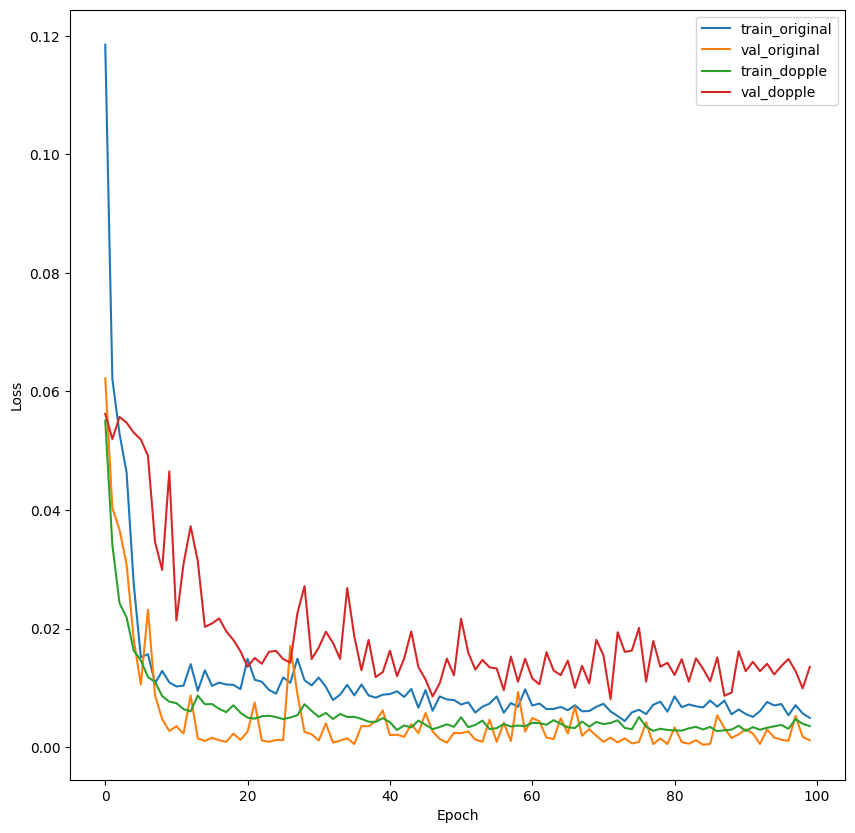

In [98]:
plt.figure(figsize=(10,10))
plt.plot(trainingEpoch_loss, label='train_original')
plt.plot(validationEpoch_loss,label='val_original')
# plt.plot(trainingEpoch_no_dp_loss, label='train_no_dp_synthetic')
# plt.plot(validationEpoch_no_dp_loss,label='val_no_dp_synthetic')
# plt.plot(trainingEpoch_dp_loss, label='train_dp_eps=1_synthetic')
# plt.plot(validationEpoch_dp_loss,label='val_dp_eps=1_synthetic')
# plt.plot(trainingEpoch_dp_eps5_loss, label='train_dp_eps=5_synthetic')
# plt.plot(validationEpoch_dp_eps5_loss,label='val_dp_eps=5_synthetic')
# plt.plot(trainingEpoch_dp_eps20_loss, label='train_dp_eps=20_synthetic')
# plt.plot(validationEpoch_dp_eps20_loss,label='val_dp_eps=20_synthetic')
plt.plot(trainingEpoch_dopple_loss, label='train_dopple')
plt.plot(validationEpoch_dopple_loss,label='val_dopple')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show